In [1]:
import pandas as pd
import os 
import pickle

from datetime import datetime

import nltk
import string
import re
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sn

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# 1. Data processing

In [2]:
df = pd.read_csv('dataset/review_bubble_tea_NYC.csv')
df.sample(5)

,name,date,text,stars,useful,funny,cool
7407,gong-cha-new-york-9,12/23/2014,Earl grey tea 3j $4 (medium size)- I love earl...,5.0,0,0,0
10023,kung-fu-tea-new-york-34,7/29/2019,They recently opened up which may explain the ...,4.0,1,0,1
8227,coco-fresh-tea-and-juice-new-york-7,6/2/2016,ROTD 9/3/2016 I love this CoCo so much solely ...,5.0,16,11,14
9823,yaya-tea-garden-new-york-3,11/8/2015,"Their rice balls are pretty decent. However, i...",2.0,0,0,0
4378,teado-tea-shop-new-york-6,3/18/2014,"Yelp, you seriously need to stop removing my h...",4.0,2,2,2


# 1. Data processing
## Missing Value

In [3]:
print('number of missing review : %d'%df.text.isna().sum())

number of missing review : 7


In [4]:
# drop NAN
df.dropna(inplace=True)

# 1. Data processing
## Clean up the review text
### (1) convert text to lower case
### (2) remove stop words
### (3) lemmatize words

In [5]:
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    try:
        text = text.lower()
    except:
        print(text)
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

df['text_basic_clean'] = df.text.map(lambda x : basic_clean(x))
df['text_len'] = df.text.apply(len)

Text(0.5, 1.0, 'text length distribution')

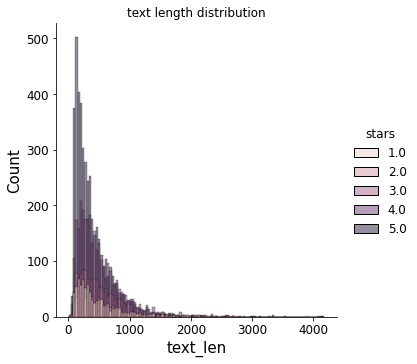

In [6]:
sn.displot(data=df, x='text_len', hue='stars')
plt.title('text length distribution')

In [7]:
# remove the text longer than 2000 to make machine learning easier
df = df[df.text_len < 2000]

# make sure the reviews are written in english
check_alpha_num = lambda x : sum([not i.encode('utf-8').isalnum() for i in x])==0
df = df[df.text_basic_clean.map(check_alpha_num)]
df.reset_index(drop=True, inplace=True)


In [8]:
# convert date to datetime data type
df.date = df.date.map(lambda x : datetime.strptime(x, '%m/%d/%Y'))

# get year and month
df['Year'] = df.date.map(lambda x : x.year)
df['Month'] = df.date.map(lambda x : x.month)

In [9]:
print('total number of bubble tea shops : %d'%len(df.name.unique()))
print('length of the dataset : %d'%len(df))

total number of bubble tea shops : 97
length of the dataset : 10152


# 2. Exploratory Data Analysis
## (a) The Distribution of Ratings

<AxesSubplot:ylabel='Rating'>

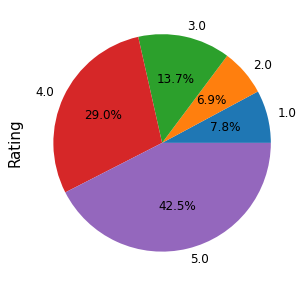

In [10]:
stars_count = df.groupby('stars').count().name
stars_count.name = 'Rating'
stars_count.plot.pie(autopct="%.1f%%", figsize=(5, 5))

# 2. Exploratory Data Analysis
## (b) Number of Reviews over Time

In [11]:
def count_dataframe_by_group(df, groupname):
    review_counts = pd.DataFrame(df.groupby(groupname).count().name)
    review_counts.reset_index(inplace=True)
    review_counts.columns = [groupname, 'count']
    return review_counts

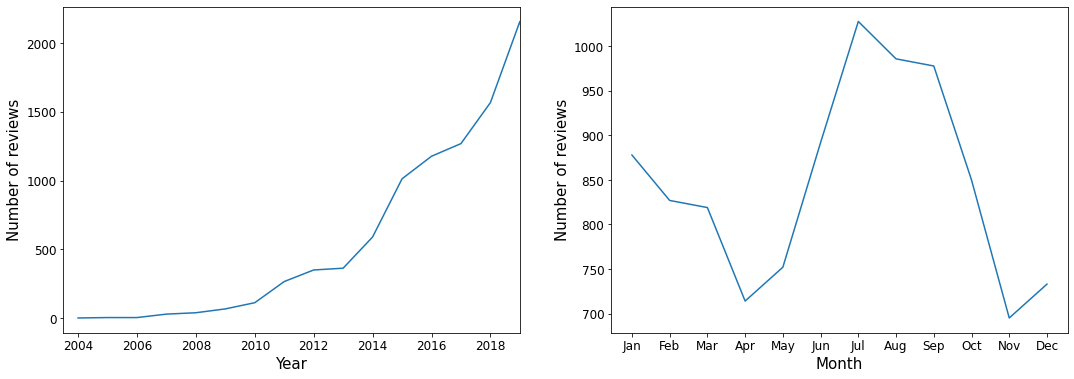

In [12]:
review_counts_year = count_dataframe_by_group(df, "Year")
review_counts_month = count_dataframe_by_group(df, "Month")

plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

sn.lineplot(data=review_counts_year, x='Year', y='count', ax=ax1)
sn.lineplot(data=review_counts_month, x='Month', y='count', ax=ax2)
ax1.set_xlim([2003.5, 2019])
ax1.set_ylabel('Number of reviews');
ax2.set_ylabel('Number of reviews');

month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec' ]
ax2.set_xticks(range(1,13))
ax2.set_xticklabels(month);

# 2. Exploratory Data Analysis
## (c) most popular flavors and drinks

In [13]:
#########################################
# Get the menu item from review text
# Compare the n-gram words with menu, save the n-gram words. 
# However simetimes there are doule-counting issue. For example,
# the function would extract "passion fruit green tea" and "green tea" at tme same time
# To avoid this issue, we simply remove the shorter n-gram using "remove_duplicate_menu"

def remove_duplicate_menu(text, words):
    words.sort(key=lambda x: -len(x.split()))  # Sort desc by number of words
    results = []
    for word in words:
        if word in text:
            text = text.replace(word, '')
            results.append(word)
    return results

def get_menu_item(text_basic_clean, lexicon):
    words = set()
    for n in range(6, 0, -1):
        n_grams = set([' '.join(text_ngram) for text_ngram in nltk.ngrams(text_basic_clean,n)])
        words = words.union(n_grams.intersection(lexicon))
    return remove_duplicate_menu(' '.join(text_basic_clean), list(words))



In [14]:
menu = pd.read_csv('dataset/bubble_tea_lexicon.csv')
drink_lexicon = set(menu.menu)


df['mentioned_drinks'] = [get_menu_item(text_cleaned, drink_lexicon) 
                            for text_cleaned in df.text_basic_clean]

mentioned_drinks_good_review_count = dict()
for i in df[df.stars==5].mentioned_drinks:
    for j in i:
        if j not in mentioned_drinks_good_review_count:
            mentioned_drinks_good_review_count[j] = 0
        mentioned_drinks_good_review_count[j] += 1
        
        
mentioned_drinks_good_review_count = pd.DataFrame.from_dict(mentioned_drinks_good_review_count, orient='index')
mentioned_drinks_good_review_count.reset_index(inplace=True)

mentioned_drinks_good_review_count.columns = ['item', 'count']
mentioned_drinks_good_review_count.sort_values('count', ascending=False, inplace=True)

<AxesSubplot:xlabel='count', ylabel='item'>

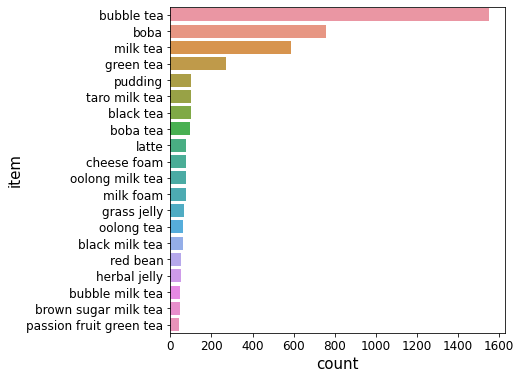

In [15]:
plt.figure(figsize=(6,6))
sn.barplot(data=mentioned_drinks_good_review_count, y='item', x='count', order=mentioned_drinks_good_review_count.item[0:20])

# 2. Exploratory Data Analysis
## (d) Word Cloud

In [17]:
good_review = list(df[df.stars==5].text_basic_clean) + list(df[df.stars==4].text_basic_clean)

good_review_str = ''
for i in good_review:
    for j in i:
        good_review_str += j
        good_review_str += ' '
        
word_cloud_good = WordCloud(width = 500, height = 500, background_color='white').generate(good_review_str)

bad_review = list(df[df.stars==1].text_basic_clean) + list(df[df.stars==2].text_basic_clean)

bad_review_str = ''
for i in bad_review:
    for j in i:
        bad_review_str += j
        bad_review_str += ' '
        
word_cloud_bad = WordCloud(width = 500, height = 500).generate(bad_review_str)



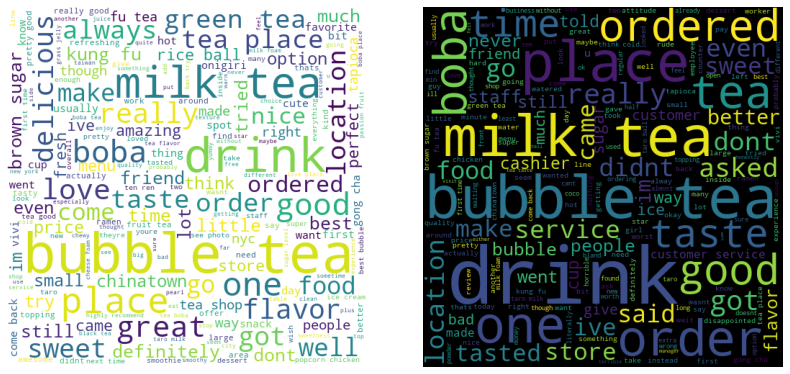

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(word_cloud_good)
plt.axis('off');

plt.subplot(122)
plt.imshow(word_cloud_bad)
plt.axis('off');
plt.tight_layout(pad=0)


# 3. Topic Modeling : Latent Dirichlet Allocation 

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# 3. Topic Modeling : Latent Dirichlet Allocation 
## (a) TF-IDF vectorizer
1. discard words that appear in > 90% of the reviews
2. discard words that appear in < 10 reviews   
3. compute Term Frequency X Inverse Document Frequency (tfidf)

In [20]:
#####################################################################
# get the review with 1-star
review = (list(df[df.stars==1].text_basic_clean.map(lambda x : ' '.join(x))) )


#####################################################################
# vectorize the text
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    ngram_range = (1,3),
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    max_df = 0.8,                        
                                    min_df = 10)                         

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
X_train = tfidf_vectorizer.fit_transform(review) 

# keep the feature name for later use
feature_names = tfidf_vectorizer.get_feature_names()

/Users/zpcian/Library/Python/3.7/lib/python/site-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [21]:
r,c = X_train.shape

print("number of reviews = %d"%r)
print("number of terms = %d"%c)

number of reviews = 796
number of terms = 616


# 3. Topic Modeling : Latent Dirichlet Allocation 
## (b) Grid Search Hyperparameter Tuning
Try differnet n_components parameters to find the best number of topics

In [22]:
#################################################
## Grid Search Hyperparameter Tuning

## Define Search Parammeters
params = {'n_components': [3,4,5,6], 'random_state' : [0]}

## Do the Grid Search
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=params)
model.fit(X_train)

## find the best model
best_model = model.best_estimator_

print("Best Model's Parameters: ", model.best_params_)

Best Model's Parameters:  {'n_components': 3, 'random_state': 0}


In [23]:
num_words = 20

all_topics = {}
for idx, topic in enumerate(best_model.components_):
    all_topics["Topic %d"%(idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-num_words - 1:-1]]
    
topics = pd.DataFrame(all_topics)

In [24]:
print(topics)

     Topic 1     Topic 2           Topic 3
0      order         tea               tea
1   customer        milk            bubble
2       time      bubble             drink
3      drink    milk tea        bubble tea
4    service        like           service
5     minute       taste             fruit
6       dont        boba          customer
7       line       drink              star
8      staff  bubble tea  customer service
9       told        taro               bad
10     store       sugar           ordered
11    people       place             fresh
12      rude     ordered             piece
13      make      tasted             place
14      said       sweet             order
15     didnt         ice              gave
16      wait         got           cashier
17      food        good             straw
18       say       worst           mistake
19      card      flavor          horrible
